In [1]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Linux-6.1.85+-x86_64-with-glibc2.35


In [2]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

/bin/bash: line 1: nvidia-smi: command not found
Tensorflow version 2.18.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

!pip install imgaug # reinstall imgaug to ensure compatibility

In [5]:
MyDrive = '/content/drive/MyDrive'
PROJECT_DIR = '/Real Life Violence Dataset'

## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [6]:
import cv2
import os
import numpy as np
import imageio
import albumentations as A

IMG_SIZE = 128
ColorChannels = 3

# Define augmentations using Albumentations
augmentations = A.Compose([
    A.HorizontalFlip(p=1.0),  # Flip image horizontally
    A.Affine(scale=(1.3, 1.3)),  # Zoom
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0),  # Brightness adjustment
    A.Rotate(limit=25)  # Rotation
])

def video_to_frames(video_path):
    vidcap = cv2.VideoCapture(video_path)
    if not vidcap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return []

    ImageFrames = []
    frame_id = 0

    while True:
        success, image = vidcap.read()
        if not success:
            break  # Exit loop when video ends

        # Skip frames to avoid duplication
        if frame_id % 7 == 0:
            # Apply augmentations
            augmented = augmentations(image=image)['image']

            # Convert BGR to RGB
            rgb_img = cv2.cvtColor(augmented, cv2.COLOR_BGR2RGB)

            # Resize image
            resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
            ImageFrames.append(resized)

        frame_id += 1

    vidcap.release()
    return ImageFrames


In [ ]:
!pip install albumentations
%%time
from tqdm import tqdm

VideoDataDir = MyDrive + PROJECT_DIR
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')),
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []


CLASSES = ["NonViolence", "Violence"]

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:150])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

ERROR: Invalid requirement: 'albumentations%%time': Expected end or semicolon (after name and no valid version specifier)
    albumentations%%time
                  ^
we have 
1000 Violence videos 
1000 NonViolence videos


100%|██████████| 150/150 [00:54<00:00,  2.75it/s]


In [8]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

5955

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [10]:
!pip install imutils
clear_output()

In [11]:
!pip install numpy --upgrade
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [12]:
epochs = 50

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor)

    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

<ipython-input-12-03db218e8456>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(pooling='avg',


Compiling model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [14]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [15]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 128, 128, 3))
  warnings.warn(msg)


1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4642 - loss: 0.9547

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 0.79332, saving model to ModelWeights.weights.h5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 150s 129ms/step - accuracy: 0.4642 - loss: 0.9546 - val_accuracy: 0.5395 - val_loss: 0.7933 - learning_rate: 1.0000e-05
Epoch 2/50
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5930 - loss: 0.7285
Epoch 2: val_loss improved from 0.79332 to 0.57588, saving model to ModelWeights.weights.h5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 109s 104ms/step - accuracy: 0.5931 - loss: 0.7284 - val_accuracy: 0.6939 - val_loss: 0.5759 - learning_rate: 1.8000e-05
Epoch 3/50
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7347 - loss: 0.5210
Epoch 3: val_loss improved from 0.57588 to 0.42499, saving model to ModelWeights.weights.h5
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 106s 102ms/step - accuracy: 0.7347 - loss: 0.5210 - val_accuracy: 0.8036 - val_loss: 0.4250 - learning_rate: 2.6000e-05
Epoch 4/50
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8291 - loss: 0.3800
Epoch 4

In [16]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i

def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  34
Accuracy on train: 0.9630517959594727 	Loss on train: 0.10647670179605484
Accuracy on test: 0.9535534381866455 	Loss on test: 0.1250389814376831


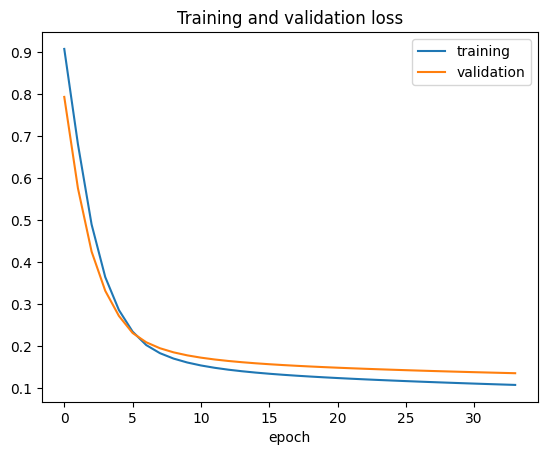

<Figure size 640x480 with 0 Axes>

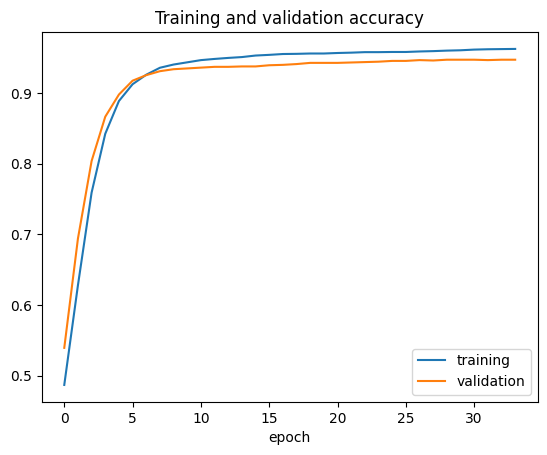

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [17]:
model_summary(model, history)

## **Evaluation on test set**

In [18]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step


> Correct Predictions: 1704
> Wrong Predictions: 83


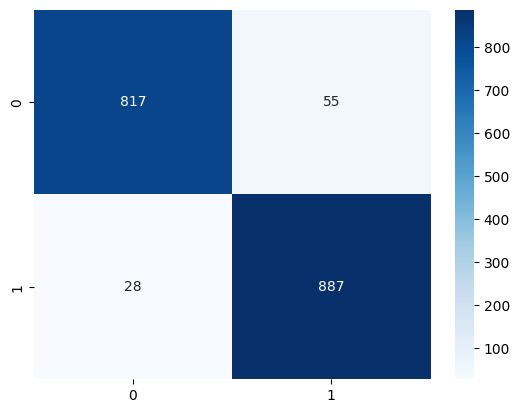

              precision    recall  f1-score   support

 NonViolence       0.97      0.94      0.95       872
    Violence       0.94      0.97      0.96       915

    accuracy                           0.95      1787
   macro avg       0.95      0.95      0.95      1787
weighted avg       0.95      0.95      0.95      1787



In [23]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix # Removed plot_roc_curve

corr_pred = metrics.confusion_matrix(y_test, preds)

# Use the built-in int instead of np.int
n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds,
                           target_names=["NonViolence", "Violence"]))

In [ ]:
args_model = "modelnew.h5"
model.save(args_model)